In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# 1. Charger les données
data_path = '/Users/tommasospreij/Desktop/REME projet/Crimes_Not_Subject_to_Expulsion_by_Residency_Status_cleaned.xlsx'
df = pd.read_excel(data_path)

# 2. Créer les variables DiD
df['T'] = (df['group'] == 'Foreigner').astype(int)
df['P'] = (df['year'] >= 2017).astype(int)
df['T_P'] = df['T'] * df['P']

# 3. Supprimer les valeurs nulles ou <= 0 pour le log
df = df[df['crime_rate_per_100k'] > 0].copy()

# 4. Créer une colonne log(crime_rate)
df['log_crime'] = np.log(df['crime_rate_per_100k'])

# 5. Régression log-crime DiD
model = smf.ols("log_crime ~ T + P + T_P", data=df).fit()

# 6. Résultats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_crime   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1509.
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.86e-27
Time:                        21:15:53   Log-Likelihood:                 48.128
No. Observations:                  28   AIC:                            -88.26
Df Residuals:                      24   BIC:                            -82.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5105      0.018    424.108      0.0

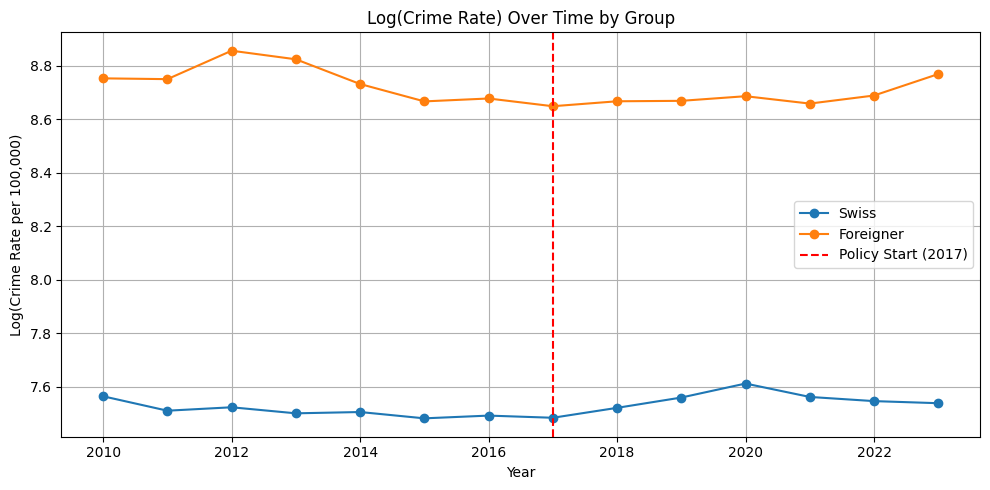

In [2]:
import matplotlib.pyplot as plt

# Calculer la moyenne des log(crime_rate) par groupe et année
mean_log_crime = df.groupby(['year', 'group'])['log_crime'].mean().unstack()

# Tracer
plt.figure(figsize=(10, 5))
plt.plot(mean_log_crime.index, mean_log_crime['Swiss'], marker='o', label='Swiss')
plt.plot(mean_log_crime.index, mean_log_crime['Foreigner'], marker='o', label='Foreigner')

# Ligne verticale pour 2016
plt.axvline(x=2017, color='red', linestyle='--', label='Policy Start (2017)')

# Titres et légendes
plt.title('Log(Crime Rate) Over Time by Group')
plt.xlabel('Year')
plt.ylabel('Log(Crime Rate per 100,000)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

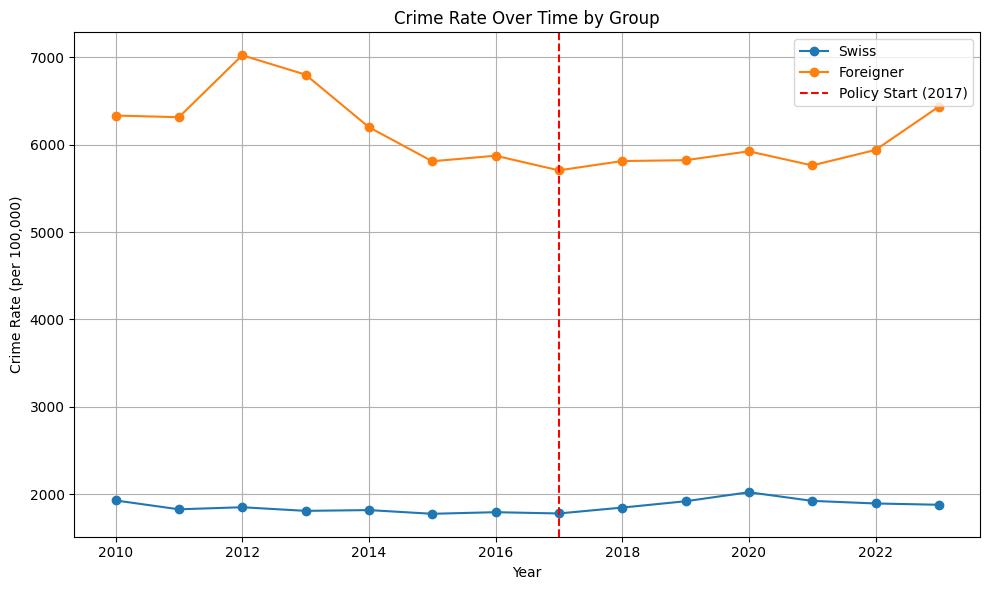

In [3]:
import matplotlib.pyplot as plt

# === 1. Load the cleaned dataset with crime rates ===
data_path = '/Users/tommasospreij/Desktop/REME projet/Crimes_Not_Subject_to_Expulsion_by_Residency_Status_cleaned.xlsx'
df = pd.read_excel(data_path)

# === 2. Pivot the data to make plotting easier ===
pivot_df = df.pivot(index='year', columns='group', values='crime_rate_per_100k')

# === 3. Plot the trends ===
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index, pivot_df['Swiss'], label='Swiss', marker='o')
plt.plot(pivot_df.index, pivot_df['Foreigner'], label='Foreigner', marker='o')

# === 4. Add vertical line for policy implementation year ===
plt.axvline(x=2017, color='red', linestyle='--', label='Policy Start (2017)')

# === 5. Add labels and legend ===
plt.title('Crime Rate Over Time by Group')
plt.xlabel('Year')
plt.ylabel('Crime Rate (per 100,000)')
plt.legend()
plt.grid(True)

# === 6. Show plot ===
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# === 1. Charger les données ===
df = pd.read_excel('/Users/tommasospreij/Desktop/REME projet/Crimes_Not_Subject_to_Expulsion_by_Residency_Status_cleaned.xlsx')

# === 2. Garder uniquement les années avant la loi (2008–2016 inclus) ===
df = df[df['year'] < 2017]

# === 3. Créer les variables ===

# Groupe traité : 1 si étranger, 0 si suisse
df['T'] = (df['group'] == 'Foreigner').astype(int)

# Temps centré (0 = 2008, 1 = 2009, etc.)
df['t'] = df['year'] - df['year'].min()

# Interaction : groupe traité × temps
df['T_t'] = df['T'] * df['t']

# Log du nombre de prévenus
df['log_count'] = np.log(df['count'] + 1)

# === 4. Régression : test de pentes parallèles ===
model = smf.ols("log_count ~ T_t", data=df).fit()

# === 5. Résultat ===
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     18.47
Date:                Wed, 07 May 2025   Prob (F-statistic):           0.000736
Time:                        21:17:35   Log-Likelihood:                 26.949
No. Observations:                  16   AIC:                            -49.90
Df Residuals:                      14   BIC:                            -48.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6573      0.015    783.144      0.0

/Users/tommasospreij/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [5]:
import pandas as pd
import statsmodels.formula.api as smf

# === 1. Load your cleaned dataset ===
data_path = '/Users/tommasospreij/Desktop/REME projet/Crimes_Not_Subject_to_Expulsion_by_Residency_Status_cleaned.xlsx'
df = pd.read_excel(data_path)

# === 2. Create DiD interaction variable ===
df['T'] = (df['group'] == 'Foreigner').astype(int)
df['P'] = (df['year'] >= 2017).astype(int)
df['T_P'] = df['T'] * df['P']  # interaction term

# === 3. Run regression with group and year fixed effects ===
model = smf.ols("crime_rate_per_100k ~ T_P + C(group) + C(year)", data=df).fit()

# === 4. Display results ===
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.994
Model:                             OLS   Adj. R-squared:                  0.987
Method:                  Least Squares   F-statistic:                     140.0
Date:                 Wed, 07 May 2025   Prob (F-statistic):           4.13e-11
Time:                         21:18:17   Log-Likelihood:                -182.21
No. Observations:                   28   AIC:                             396.4
Df Residuals:                       12   BIC:                             417.7
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5945.6093